# Set Up

In [7]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so

import glob
import os

from scipy import stats

In [8]:
sns.set_theme()

PATH_TO_LOGS = os.getcwd()+"/logs/"
print(PATH_TO_LOGS)

TIME_BTN_POWER = 0.5

/Users/cjparra/Work/wfey/logs/


# Processing Logs

In [26]:
CONFIGS=["busypoll_nodb_wfey", "busypoll_db_wfey", "wfe_nodb_wfey", "wfe_db_nomon_wfey"]
#CONFIGS=["wfe_db_nomon_wfey"]
NUMEVENTS=[10, 50, 100]
EVENTPROCCPUS=[ "1" ]
SLEEPTIME=[ "0.001", "0.01" ]
#SOURCECPUS=[  "2", "2 3", "2 81", "81 82", "2 3 4", "2 3 4 5 6" ]
SOURCECPUS=[  "2", "2 3", "2 3 4", "2 3 4 5 6" ]

arr = []
data = []

def processData(CONFIGS, NUMEVENTS, EVENTPROCCPUS, SLEEPTIME, SOURCESCPUS, VERBOSE=False):
    for C in CONFIGS:
        for EVENTS in NUMEVENTS:
            for EVENTCPU in EVENTPROCCPUS:
                for SLEEP in SLEEPTIME:
                    for SOURCECPU in SOURCECPUS:
                        SCPUs=SOURCECPU.replace(" ", "_")
                        
                        FILE=PATH_TO_LOGS+C+"/"+str(EVENTS)+"_"+EVENTCPU+"_"+SLEEP+"_"+SCPUs+"/"
                        HWMONFILE=glob.glob(FILE+'hwmon-*.out')

                        ### For every run of this set of parameters concat
                        hwmonoutput=None
                        latencyoutput=None
                        
                        for runs in HWMONFILE:
                            if os.path.exists(runs):
                                if VERBOSE:
                                    print("processsing:" + runs)
                                    
                                df=pd.read_csv(runs, sep=' ')

                                hwmonoutput = pd.concat([hwmonoutput, df])

                                ## --- Grabbing Latency Numbers --- ##
                                latency_file = runs.replace("hwmon", "latency")

                                if os.path.exists(latency_file):
                                    if VERBOSE:
                                        print("processsing:" + latency_file)

                                    latency_df = pd.read_csv(latency_file)

                                    latencyoutput = pd.concat([latencyoutput, latency_df])

                        #print(hwmonoutput)
                        #print(latencyoutput)
                                    

                        ## --- Find the mean of all runs --- ##
                        by_row_index = hwmonoutput.groupby(hwmonoutput.index)
                        results=by_row_index.mean()

                        ## --- Find Means of Latencys --- ###
                        ### This means that the individual data for the sources is not saved 
                        ### But I believe that's fine bc we don't care about the about the data
                        ### at the cpu scale but the number of cpu handling the workload
                        
                        latency_results=latencyoutput.drop("ID", axis=1)

                        latency_min = latency_results.loc[:,"Min"].to_numpy()
                        latency_max = latency_results.loc[:,"Max"].to_numpy()
                        latency_mean = latency_results.loc[:,"Mean"].to_numpy()

                        latency_min = stats.gmean(latency_min)
                        latency_max = stats.gmean(latency_max)
                        latency_mean = stats.gmean(latency_mean)

                        ## --- Getting time for every power number -- #
                        
                        runningtime = len(results.index) * TIME_BTN_POWER
                        
                        time_range = np.arange(0, runningtime, TIME_BTN_POWER)
                        #print(time_range)
                        
                        ## --- Making array out of hwmon output --- ##
                        hwmon2_pwr = results.loc[:,"hwmon2"].to_numpy()
                        hwmon3_pwr = results.loc[:,"hwmon3"].to_numpy()

                        ## --- Processing HWMON Numbers --- ## 
                        hwmon2_min = hwmon2_pwr.min()
                        hwmon3_min = hwmon3_pwr.min()

                        hwmon2_max = hwmon2_pwr.max()
                        hwmon3_max = hwmon3_pwr.max()

                        hwmon2_mean = stats.gmean(hwmon2_pwr)
                        hwmon3_mean = stats.gmean(hwmon3_pwr)

                        ## --- Adding data to list --- ##
                        
                        arr.append((C,EVENTS,SLEEP,EVENTCPU,SCPUs,hwmon2_pwr,hwmon3_pwr, hwmon2_min, hwmon2_max, hwmon2_mean, hwmon3_min, hwmon3_max, hwmon3_mean, time_range, latency_min, latency_max, latency_mean))

    df = pd.DataFrame(data=arr, columns=[ "configs", "numevents", "sleeptime", "eventprocCPUs", "sourceCPUs", "hwmon2", "hwmon3", "hwmon2_min", "hwmon2_max", "hwmon2_mean", "hwmon3_min", "hwmon3_max", "hwmon3_mean", "time", "latency_min", "latency_max", "latency_mean"])
    return df

## --- End of processData() --- ##

wfey_output = processData(CONFIGS, NUMEVENTS, EVENTPROCCPUS, SLEEPTIME, SOURCECPUS)
#print(wfey_output)

flat_data = wfey_output.explode(["hwmon2","hwmon3","time"], ignore_index=True)
#print(flat_data)

# Graphs

## Heat Map

<Axes: >

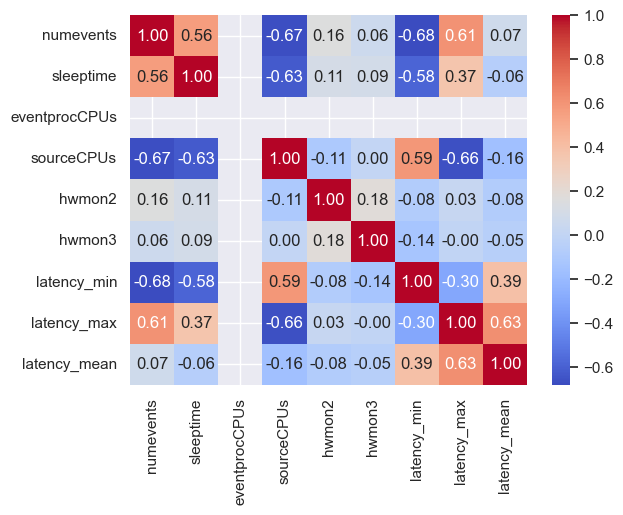

In [27]:
#sns.pairplot(data=flat_data, hue="configs")
corr = flat_data[['numevents', 'sleeptime', 'eventprocCPUs', 'sourceCPUs', 'hwmon2', 'hwmon3', 'latency_min', 'latency_max', 'latency_mean']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')

## Correlations with the HW Monitor Numbers

### HWMON2

#### Choosing subsets of plots

In [28]:
eventsubset=[10, 100]
sleeptimesubset=["0.001"]
#sourceCPUsubset=["2", "2_3_4", "2_3_4_5_6"]
sourceCPUsubset=["2"]

#### Power Graphs

##### Average Power Numbers across all arg configs for each wfey Config

##### Power values over time -- Differentiated by NumEvents

17440000.0


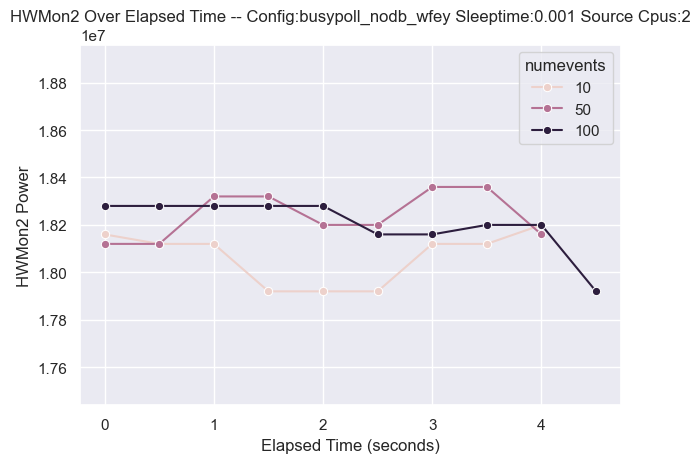

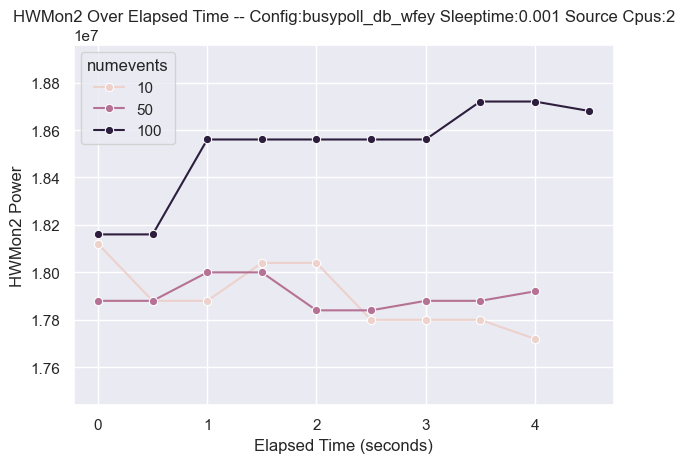

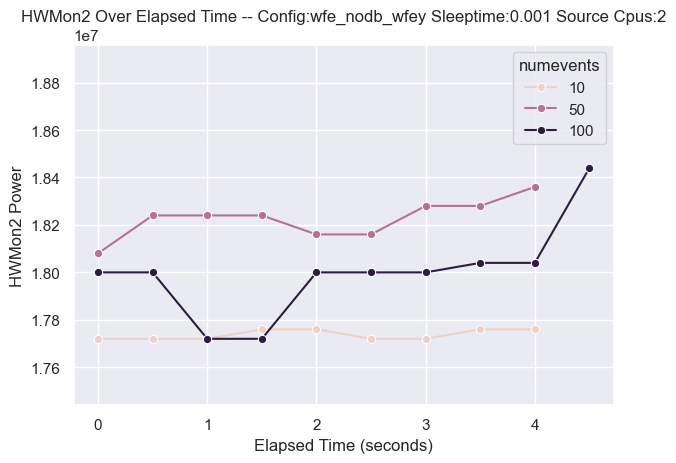

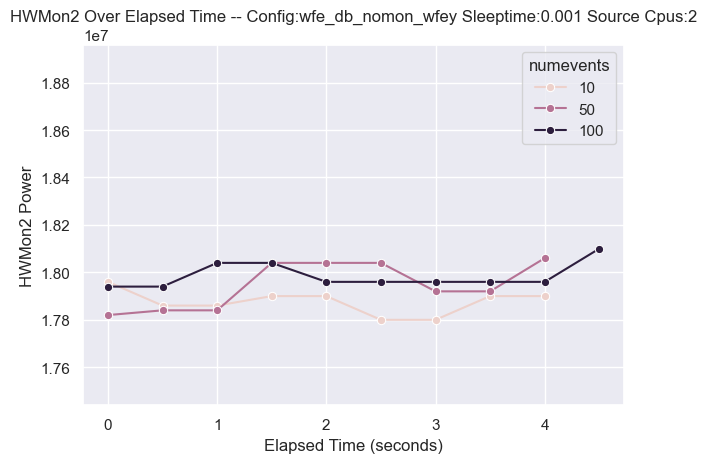

In [42]:
for c in CONFIGS:
    for s in sleeptimesubset:
        for sc in sourceCPUsubset:
            plt.figure()
            config_set = flat_data[ (flat_data['configs'] == c) &
                                    (flat_data['sleeptime'] == s) &
                                    (flat_data['sourceCPUs'] == sc)]
            #print(config_set)
            sns.lineplot(
                data=config_set, 
                x='time',
                y='hwmon2',
                hue='numevents',
                marker='o',        # Adds markers at each point
                errorbar=None
            )
            
            plt.title('HWMon2 Over Elapsed Time -- Config:'+c+' Sleeptime:'+s+' Source Cpus:'+sc)
            plt.xlabel('Elapsed Time (seconds)')
            plt.ylabel('HWMon2 Power')
            plt.ylim(flat_data['hwmon2_min'].min(),flat_data['hwmon2_max'].max())
            plt.tight_layout()

##### Power values over time -- Differentiated by NumEvents -- Standarized 

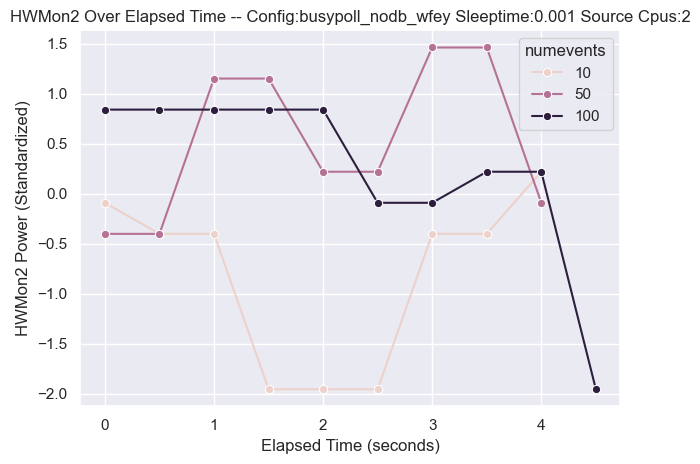

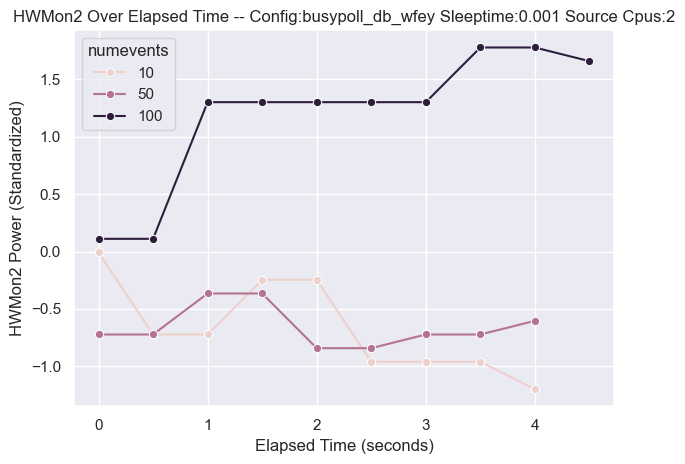

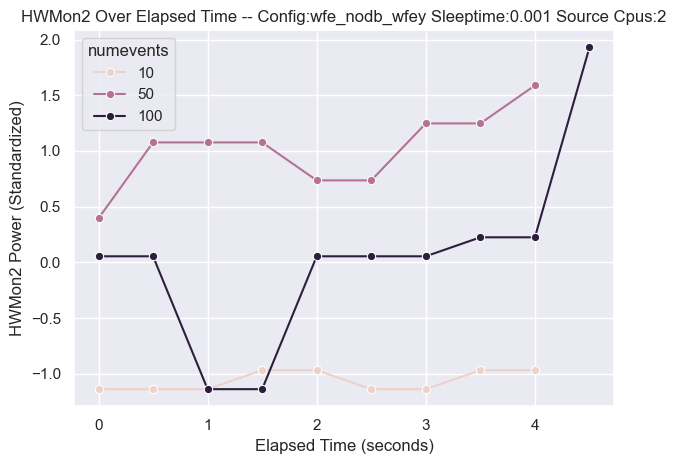

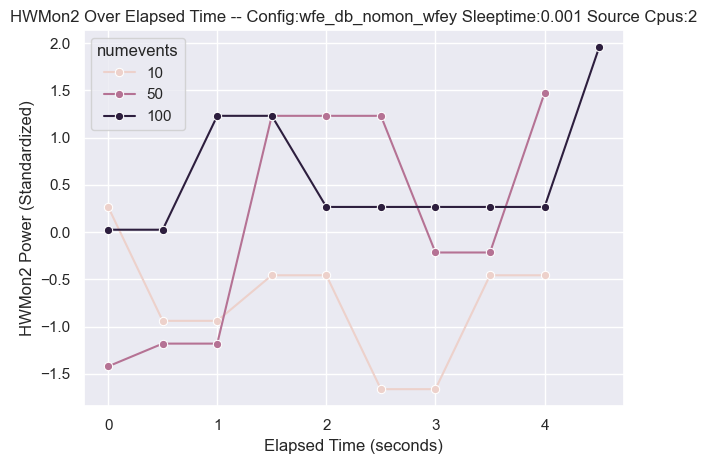

In [45]:
for c in CONFIGS:
    for s in sleeptimesubset:
        for sc in sourceCPUsubset:
            plt.figure()
            config_set = flat_data[ (flat_data['configs'] == c) &
                                    (flat_data['sleeptime'] == s) &
                                    (flat_data['sourceCPUs'] == sc)]
            
            mean_set = config_set.assign( hwmon2_standard = (config_set['hwmon2'] - config_set['hwmon2'].mean()) / (config_set['hwmon2'].std()) )
            #print(mean_set)
            
            sns.lineplot(
            data=mean_set, 
                x='time',
                y='hwmon2_standard',
            hue='numevents',
            marker='o',        # Adds markers at each point
                errorbar=None
            )
        
            plt.title('HWMon2 Over Elapsed Time -- Config:'+c+' Sleeptime:'+s+' Source Cpus:'+sc)
            plt.xlabel('Elapsed Time (seconds)')
            plt.ylabel('HWMon2 Power (Standardized)')
            plt.tight_layout()

##### Power values over time -- Differentiated by Config

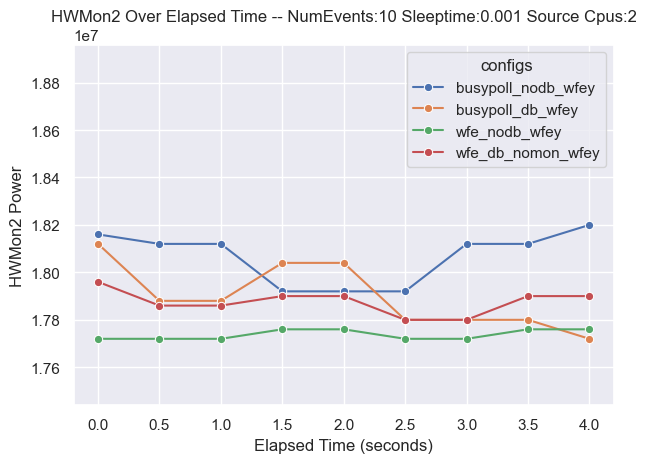

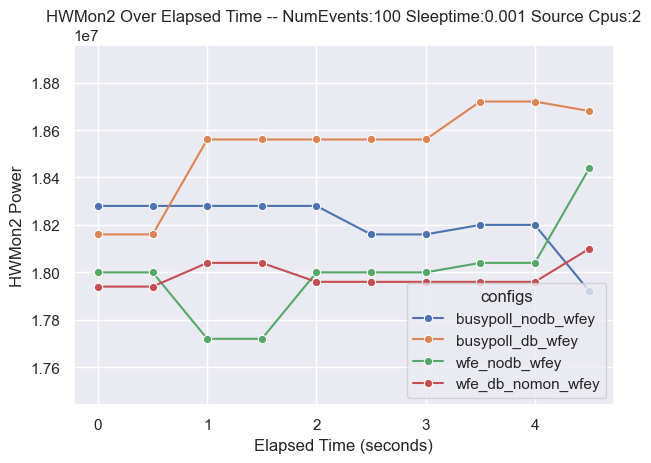

In [47]:
for e in eventsubset:
    for s in sleeptimesubset:
        for sc in sourceCPUsubset:
            plt.figure()
            config_set = flat_data[ (flat_data['numevents'] == e) &
                                    (flat_data['sleeptime'] == s) &
                                    (flat_data['sourceCPUs'] == sc)]
            #print(config_set)
            sns.lineplot(
            data=config_set, 
                x='time',
                y='hwmon2',
            hue='configs',
            marker='o',        # Adds markers at each point
                errorbar=None
            )
        
            plt.title('HWMon2 Over Elapsed Time -- NumEvents:'+str(e)+' Sleeptime:'+s+' Source Cpus:'+sc)
            plt.xlabel('Elapsed Time (seconds)')
            plt.ylabel('HWMon2 Power')
            plt.ylim(flat_data['hwmon2_min'].min(),flat_data['hwmon2_max'].max())
            plt.tight_layout()

##### Power values over time -- Differentiated by Config -- Standarized

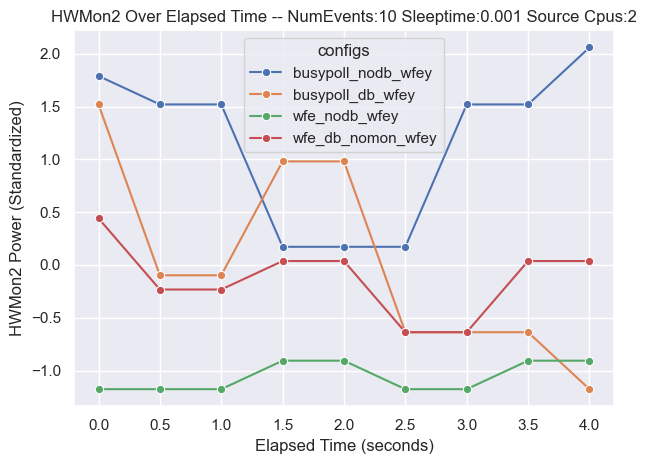

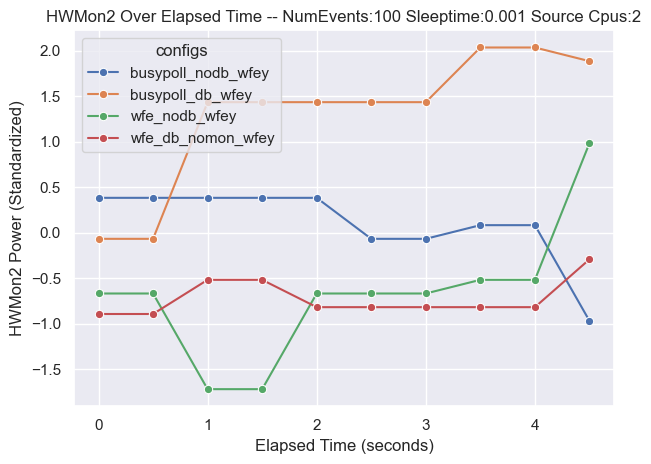

In [48]:
for e in eventsubset:
    for s in sleeptimesubset:
        for sc in sourceCPUsubset:
            plt.figure()
            config_set = flat_data[ (flat_data['numevents'] == e) &
                                    (flat_data['sleeptime'] == s) &
                                    (flat_data['sourceCPUs'] == sc)]
            #print("config: ")
            #print(config_set)

            ## Is this giving me the power numbers mean standardized (z-score) over all the values
            ## over one set of values ...? Do I want it over all of them... b/c they might start 
            ## at different values
            mean_set = config_set.assign( hwmon2_standard = (config_set['hwmon2'] - config_set['hwmon2'].mean()) / (config_set['hwmon2'].std()) )
            #print(mean_set)

            #print("config set [hwmon]: ")
            #print(config_set['hwmon2'])
            
            sns.lineplot(
            data=mean_set, 
                x='time',
                y='hwmon2_standard',
            hue='configs',
            marker='o',        # Adds markers at each point
                errorbar=None
            )
        
            plt.title('HWMon2 Over Elapsed Time -- NumEvents:'+str(e)+' Sleeptime:'+s+' Source Cpus:'+sc)
            plt.xlabel('Elapsed Time (seconds)')
            plt.ylabel('HWMon2 Power (Standardized)')
            plt.tight_layout()

##### Min/Max/Mean per Config

<Figure size 640x480 with 0 Axes>

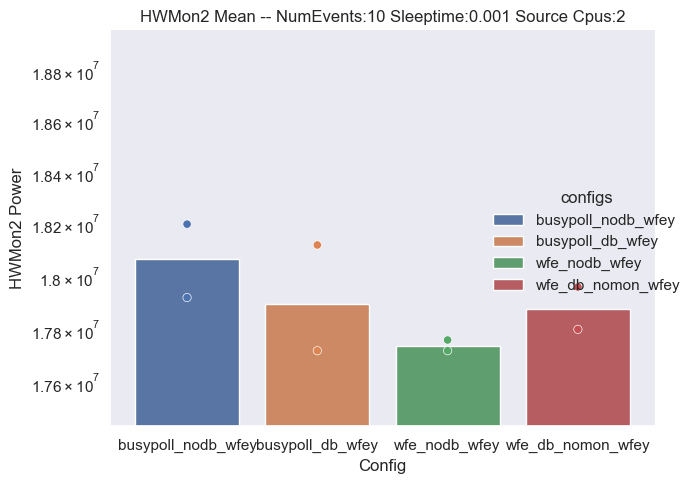

<Figure size 640x480 with 0 Axes>

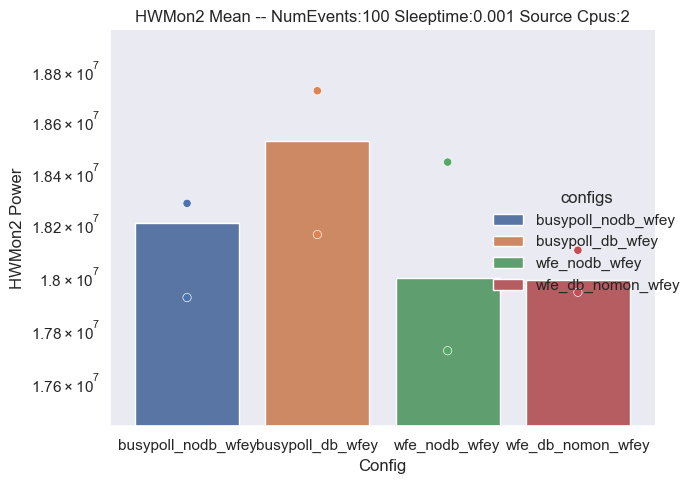

In [50]:
for e in eventsubset:
    for s in sleeptimesubset:
        for sc in sourceCPUsubset:
            plt.figure()
            config_set = wfey_output[ (wfey_output['numevents'] == e) &
                                    (wfey_output['sleeptime'] == s) &
                                    (wfey_output['sourceCPUs'] == sc)]

            #mean_set = config_set.assign( hwmon2_standard = (config_set['hwmon2'] - config_set['hwmon2'].mean()) / (config_set['hwmon2'].std()) )
            #print(config_set)
            
            g = sns.catplot(
            data=config_set, 
            kind="bar",
            x='configs',
            y='hwmon2_mean',
            hue='configs',
            legend=True,
            errorbar=None
            )

            sns.scatterplot(
            data=config_set,
            x='configs',
            y='hwmon2_min',
            hue='configs',
            legend=False
            )

            sns.scatterplot(
            data=config_set,
            x='configs',
            y='hwmon2_max',
            hue='configs',
            legend=False
            )

            g.fig.get_axes()[0].set_yscale('log')

            #plot_errorbars(lambda x: (x.min(), x.max()))
        
            plt.title('HWMon2 Mean -- NumEvents:'+str(e)+' Sleeptime:'+s+' Source Cpus:'+sc)
            plt.xlabel('Config')
            plt.ylabel('HWMon2 Power')
            plt.ylim(flat_data['hwmon2_min'].min(),flat_data['hwmon2_max'].max())
            plt.tight_layout()

#### Latency Graphs

##### Average Latency Numbers across all arg configs for each wfey Config

<Axes: xlabel='numevents', ylabel='latency_mean'>

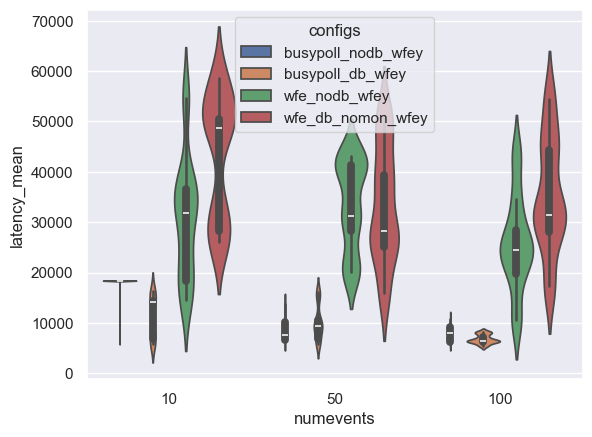

In [53]:
sns.violinplot(data=flat_data, x='numevents', y='latency_mean', hue='configs')

<Axes: xlabel='numevents', ylabel='latency_min'>

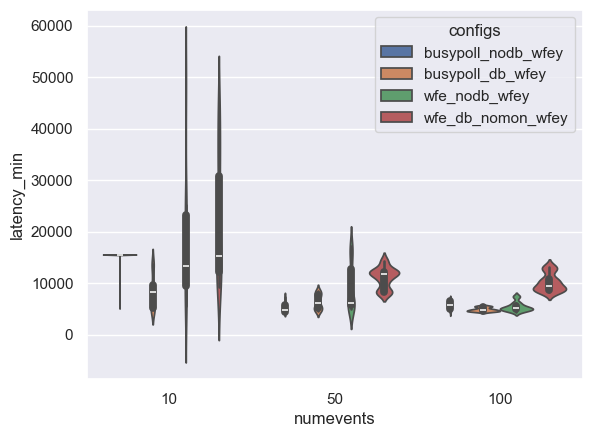

In [54]:
sns.violinplot(data=flat_data, x='numevents', y='latency_min', hue='configs')

<Axes: xlabel='numevents', ylabel='latency_max'>

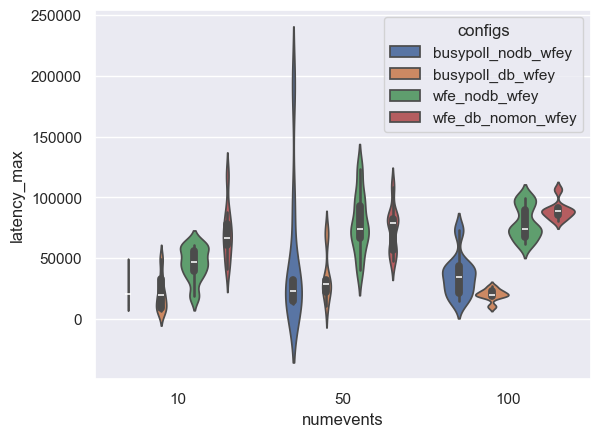

In [55]:
sns.violinplot(data=flat_data, x='numevents', y='latency_max', hue='configs')

##### Min/Max/Mean per Config

<Figure size 640x480 with 0 Axes>

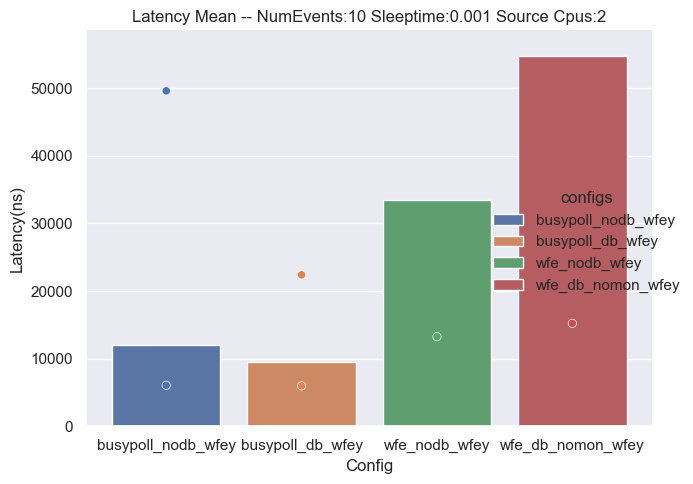

<Figure size 640x480 with 0 Axes>

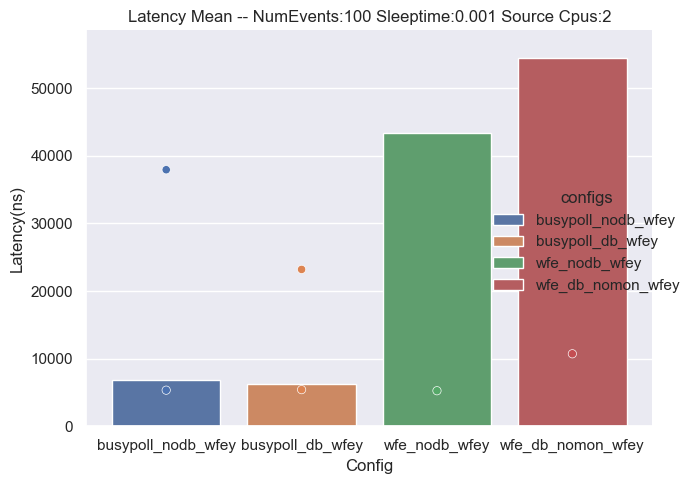

In [62]:
for e in eventsubset:
    for s in sleeptimesubset:
        for sc in sourceCPUsubset:
            plt.figure()
            config_set = wfey_output[ (wfey_output['numevents'] == e) &
                                    (wfey_output['sleeptime'] == s) &
                                    (wfey_output['sourceCPUs'] == sc)]

            #mean_set = config_set.assign( hwmon2_standard = (config_set['hwmon2'] - config_set['hwmon2'].mean()) / (config_set['hwmon2'].std()) )
            #print(config_set)
            
            g = sns.catplot(
            data=config_set, 
            kind="bar",
            x='configs',
            y='latency_mean',
            hue='configs',
            legend=True,
            errorbar=None
            )

            sns.scatterplot(
            data=config_set,
            x='configs',
            y='latency_min',
            hue='configs',
            legend=False
            )

            sns.scatterplot(
            data=config_set,
            x='configs',
            y='latency_max',
            hue='configs',
            legend=False
            )

            #g.fig.get_axes()[0].set_yscale('log')

            #plot_errorbars(lambda x: (x.min(), x.max()))
        
            plt.title('Latency Mean -- NumEvents:'+str(e)+' Sleeptime:'+s+' Source Cpus:'+sc)
            plt.xlabel('Config')
            plt.ylabel('Latency(ns)')
            plt.ylim(0,flat_data['latency_mean'].max())
            plt.tight_layout()

### HWMON 3

In [ ]:
sns.violinplot(data=flat_data, x='numevents', y='hwmon3', hue='configs')